## Introduction

In [1]:
import os
from pathlib import Path

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle: path = Path('../input/titanic')
else:
    path = Path('titanic')
    if not path.exists():
        import zipfile,kaggle
        kaggle.api.competition_download_cli(str(path))
        zipfile.ZipFile(f'{path}.zip').extractall(path)

In [2]:
import torch, numpy as np, pandas as pd
np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)

## Limpando os dados

Esta é uma competição de *dados tabulares* -- os dados estão na forma de uma tabela. Ele é fornecido como um arquivo de valores separados por vírgulas (CSV). Podemos abri-lo usando a biblioteca *pandas*, que criará um `DataFrame`.

In [3]:
df = pd.read_csv(path/'train.csv')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


Vamos multiplicar cada coluna por alguns coeficientes. Mas podemos ver na coluna `Cabin` que existem valores `NaN`, que é como o Pandas se refere aos valores ausentes. Não podemos multiplicar algo por um valor que falta!

Vamos verificar quais colunas contêm valores `NaN`. A função `isna()` do Pandas retorna `True` (que é tratado como `1` quando usado como um número) para valores `NaN`, então podemos apenas adicioná-los para cada coluna:

In [4]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Observe que, por padrão, o Pandas soma as colunas.

Precisamos substituir os valores ausentes por algo. Geralmente não importa muito o que escolhemos. Usaremos o valor mais comum (a "*moda*"). Podemos usar a função `mode` para isso. Ele retorna mais de uma linha no caso de empates, então pegamos apenas a primeira linha com `iloc[0]`:

In [5]:
modes = df.mode().iloc[0]
modes

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

In [6]:
df.fillna(modes, inplace=True)

Agora podemos verificar se não há valores ausentes:

In [7]:
df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

Veja como obtemos um resumo rápido de todas as colunas numéricas no conjunto de dados:

In [8]:
import numpy as np

df.describe(include=(np.number))

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,28.566970,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.199572,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,24.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Podemos ver que `Fare` (tarifa) contém principalmente valores em torno de `0` a `30`, mas há alguns valores realmente grandes. Isso é muito comum em campos que contêm valores monetários e pode causar problemas para o nosso modelo, pois uma vez que essa coluna é multiplicada por um coeficiente posteriormente, as poucas linhas com valores realmente grandes dominarão o resultado.

Você pode ver o problema com mais clareza visualmente observando um histograma, que mostra uma cauda longa à direita.

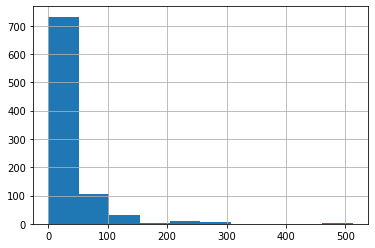

In [9]:
df['Fare'].hist();

Para corrigir isso, a abordagem mais comum é usar o logaritmo, que reduz os números grandes e torna a distribuição mais razoável. Observe, no entanto, que há zeros na coluna `Fare` e `log(0)` é infinito -- para corrigir isso, simplesmente adicionaremos `1` a todos os valores primeiro:

In [10]:
df['LogFare'] = np.log(df['Fare']+1)

O histograma agora mostra uma distribuição de valores mais uniforme sem a cauda longa:

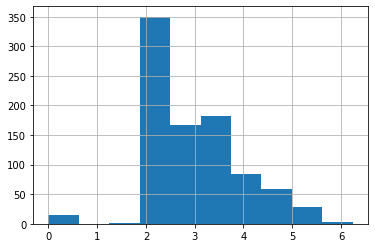

In [11]:
df['LogFare'].hist();

A partir da saída `describe()`, parece que `Pclass` contém apenas 3 valores, o que podemos confirmar olhando o [Data Dictionary].

In [12]:
pclasses = sorted(df.Pclass.unique())
pclasses

[1, 2, 3]

Veja como obtemos um resumo rápido de todas as colunas não numéricas no conjunto de dados:

In [13]:
df.describe(include=[object])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,891
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,691,646


Claramente não podemos multiplicar strings como `male` ou `S` por coeficientes, então precisamos substituí-los por números.

Fazemos isso criando novas colunas contendo *variáveis fictícias* (dummy variables). Uma variável fictícia é uma coluna que contém um `1` onde uma determinada coluna contém um valor específico ou um `0` caso contrário. Por exemplo, poderíamos criar uma variável fictícia para `Sex='male'`, que seria uma nova coluna contendo `1` para linhas onde `Sex` é `'male'` e 0 para linhas onde não é .

O pandas pode criá-las automaticamente usando `get_dummies`, que também remove as colunas originais. Criaremos variáveis fictícias para `Pclass`, mesmo que sejam numéricas, já que os números `1`, `2` e `3` correspondem a cabines de primeira, segunda e terceira classe - não a contagens ou medidas que fazem sentido para multiplicar por. Também criaremos variáveis para `Sex` e `Embarked`, pois queremos usá-los como preditores em nosso modelo. Por outro lado, `Cabin`, `Name` e `Ticket` têm muitos valores exclusivos para fazer sentido criar variáveis fictícias para eles.

In [14]:
df = pd.get_dummies(df, columns=["Sex","Pclass","Embarked"])
df.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'LogFare', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

Podemos ver que 5 colunas foram adicionadas ao final -- uma para cada um dos valores possíveis de cada uma das três colunas solicitadas e que essas três colunas solicitadas foram removidas.

Aqui está a aparência das primeiras linhas dessas colunas recém-adicionadas:

In [15]:
added_cols = ['Sex_male', 'Sex_female', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
df[added_cols].head()

,Sex_male,Sex_female,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1,0,0,0,1,0,0,1
1,0,1,1,0,0,1,0,0
2,0,1,0,0,1,0,0,1
3,0,1,1,0,0,0,0,1
4,1,0,0,0,1,0,0,1


Agora podemos criar nossas variáveis independentes (preditores) e dependentes (alvo). Ambos precisam ser tensores PyTorch. Nossa variável dependente é `Survived`:

In [16]:
from torch import tensor

t_dep = tensor(df.Survived)

Nossas variáveis independentes são todas as variáveis contínuas de interesse mais todas as variáveis fictícias que acabamos de criar:

In [17]:
indep_cols = ['Age', 'SibSp', 'Parch', 'LogFare'] + added_cols

t_indep = tensor(df[indep_cols].values, dtype=torch.float)
t_indep

tensor([[22.0000,  1.0000,  0.0000,  2.1102,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [38.0000,  1.0000,  0.0000,  4.2806,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000],
        [26.0000,  0.0000,  0.0000,  2.1889,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  1.0000,  0.0000,  3.9908,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  0.0000,  0.0000,  2.2028,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [24.0000,  0.0000,  0.0000,  2.2469,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000],
        [54.0000,  0.0000,  0.0000,  3.9677,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        ...,
        [25.0000,  0.0000,  0.0000,  2.0857,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [39.0000,  0.0000,  5.0000,  3.4054

Aqui está o número de linhas e colunas que temos para nossas variáveis independentes:Here's the number of rows and columns we have for our independent variables:

In [18]:
t_indep.shape

torch.Size([891, 12])

## Configurando um modelo linear

Agora que temos uma matriz de variáveis independentes e um vetor de variáveis dependentes, podemos trabalhar no cálculo de nossas previsões e perdas. Nesta seção, faremos manualmente uma única etapa de cálculo de previsões e perdas para cada linha de nossos dados.

Nosso primeiro modelo será um modelo linear simples. Vamos precisar de um coeficiente para cada coluna em `t_indep`. Escolheremos números aleatórios no intervalo `(-0.5,0.5)`.

In [19]:
torch.manual_seed(442)

n_coeff = t_indep.shape[1]
coeffs = torch.rand(n_coeff)-0.5
coeffs

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,  0.2799, -0.4392,  0.2103,  0.3625])

Nossas previsões serão calculadas multiplicando cada linha pelos coeficientes e somando-os. Um ponto interessante aqui é que não precisamos de um termo constante separado (também conhecido como termo "viés" ou "interceptado"), ou uma coluna de todos os `1`s para dar o mesmo efeito tendo um termo constante. Isso ocorre porque nossas variáveis fictícias já cobrem todo o conjunto de dados - por exemplo há uma coluna para "masculino" e uma coluna para "feminino", e todos no conjunto de dados estão exatamente em um deles; portanto, não precisamos de um termo de interceptação separado para cobrir linhas que não fazem parte de uma coluna.

Veja como fica a multiplicação:

In [20]:
t_indep*coeffs

tensor([[-10.1838,   0.1386,   0.0000,  -0.4772,  -0.2632,  -0.0000,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-17.5902,   0.1386,   0.0000,  -0.9681,  -0.0000,  -0.3147,   0.4876,   0.0000,   0.0000,  -0.4392,   0.0000,   0.0000],
        [-12.0354,   0.0000,   0.0000,  -0.4950,  -0.0000,  -0.3147,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-16.2015,   0.1386,   0.0000,  -0.9025,  -0.0000,  -0.3147,   0.4876,   0.0000,   0.0000,  -0.0000,   0.0000,   0.3625],
        [-16.2015,   0.0000,   0.0000,  -0.4982,  -0.2632,  -0.0000,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-11.1096,   0.0000,   0.0000,  -0.5081,  -0.2632,  -0.0000,   0.0000,   0.0000,   0.2799,  -0.0000,   0.2103,   0.0000],
        [-24.9966,   0.0000,   0.0000,  -0.8973,  -0.2632,  -0.0000,   0.4876,   0.0000,   0.0000,  -0.0000,   0.0000,   0.3625],
        ...,
        [-11.5725,   0.0000,   0.0000,  -0.4717,  -0.2632,  -0.0000,   0.0000

Podemos ver que temos um problema aqui. As somas de cada linha serão dominadas pela primeira coluna, que é `Idade`, já que é maior em média do que todas as outras.

Vamos fazer com que todas as colunas contenham números de `0` a `1`, dividindo cada coluna por seu `max()`:

In [21]:
vals,indices = t_indep.max(dim=0)
t_indep = t_indep / vals

Como vemos, isso elimina o problema de uma coluna dominar todas as outras:

In [22]:
t_indep*coeffs

tensor([[-0.1273,  0.0173,  0.0000, -0.0765, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2199,  0.0173,  0.0000, -0.1551, -0.0000, -0.3147,  0.4876,  0.0000,  0.0000, -0.4392,  0.0000,  0.0000],
        [-0.1504,  0.0000,  0.0000, -0.0793, -0.0000, -0.3147,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2025,  0.0173,  0.0000, -0.1446, -0.0000, -0.3147,  0.4876,  0.0000,  0.0000, -0.0000,  0.0000,  0.3625],
        [-0.2025,  0.0000,  0.0000, -0.0798, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.1389,  0.0000,  0.0000, -0.0814, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.2103,  0.0000],
        [-0.3125,  0.0000,  0.0000, -0.1438, -0.2632, -0.0000,  0.4876,  0.0000,  0.0000, -0.0000,  0.0000,  0.3625],
        ...,
        [-0.1447,  0.0000,  0.0000, -0.0756, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2257,  0.0000,  0.2008, -0.1234

In [23]:
preds = (t_indep*coeffs).sum(axis=1)

Vejamos os primeiros:

In [24]:
preds[:10]

tensor([ 0.1927, -0.6239,  0.0979,  0.2056,  0.0968,  0.0066,  0.1306,  0.3476,  0.1613, -0.6285])

Claro, essas previsões não serão úteis, já que nossos coeficientes são aleatórios -- eles são apenas um ponto de partida para nosso processo de gradiente descendente.

Para fazer a descida do gradiente, precisamos de uma função de perda. Tomar o erro médio das linhas (ou seja, o valor absoluto da diferença entre a previsão e o dependente) geralmente é uma abordagem razoável:

In [25]:
loss = torch.abs(preds-t_dep).mean()
loss

tensor(0.5382)

Agora que testamos uma forma de calcular previsões e perdas, vamos colocá-las em funções para facilitar:

In [26]:
def calc_preds(coeffs, indeps): return (indeps*coeffs).sum(axis=1)
def calc_loss(coeffs, indeps, deps): return torch.abs(calc_preds(coeffs, indeps)-deps).mean()

## Fazendo uma descida gradiente

In [27]:
coeffs.requires_grad_()

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,  0.2799, -0.4392,  0.2103,  0.3625], requires_grad=True)

Agora, quando calcularmos nossa perda, o PyTorch acompanhará todas as etapas, para que possamos obter os gradientes posteriormente:

In [28]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss

tensor(0.5382, grad_fn=<MeanBackward0>)

Use `backward()` para pedir ao PyTorch para calcular gradientes agora:

In [29]:
loss.backward()

Vamos ver como eles são:

In [30]:
coeffs.grad

tensor([-0.0106,  0.0129, -0.0041, -0.0484,  0.2099, -0.2132, -0.1212, -0.0247,  0.1425, -0.1886, -0.0191,  0.2043])

Observe que cada vez que chamamos `backward`, os gradientes são realmente *adicionados* ao que quer que esteja no atributo `.grad`. Vamos tentar executar as etapas acima novamente:

In [31]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss.backward()
coeffs.grad

tensor([-0.0212,  0.0258, -0.0082, -0.0969,  0.4198, -0.4265, -0.2424, -0.0494,  0.2851, -0.3771, -0.0382,  0.4085])

Como você pode ver, nossos valores `.grad` dobraram. Isso porque ele adicionou os gradientes uma segunda vez. Por esse motivo, depois de usarmos os gradientes para fazer uma etapa de descida de gradiente, precisamos defini-los de volta para zero.

Agora podemos fazer uma etapa de descida do gradiente e verificar se nossa perda diminui:

In [32]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss.backward()
with torch.no_grad():
    coeffs.sub_(coeffs.grad * 0.1)
    coeffs.grad.zero_()
    print(calc_loss(coeffs, t_indep, t_dep))

tensor(0.4945)


Observe que `a.sub_(b)` subtrai `b` de `a` no local. No PyTorch, qualquer método que termine em `_` altera seu objeto no local. Da mesma forma, `a.zero_()` define todos os elementos de um tensor como zero.

## Treinando o modelo linear

Antes de começarmos a treinar nosso modelo, precisamos garantir que tenhamos um conjunto de validação para calcular nossas métricas.

In [33]:
from fastai.data.transforms import RandomSplitter
trn_split,val_split=RandomSplitter(seed=42)(df)

Agora podemos aplicar esses índices às nossas variáveis independentes e dependentes:

In [34]:
trn_indep,val_indep = t_indep[trn_split],t_indep[val_split]
trn_dep,val_dep = t_dep[trn_split],t_dep[val_split]
len(trn_indep),len(val_indep)

(713, 178)

Vamos criar funções para as três coisas que fizemos manualmente acima: atualizar `coeffs`, fazer uma etapa completa de descida do gradiente e inicializar `coeffs` para números aleatórios:

In [35]:
def update_coeffs(coeffs, lr):
    coeffs.sub_(coeffs.grad * lr)
    coeffs.grad.zero_()

In [36]:
def one_epoch(coeffs, lr):
    loss = calc_loss(coeffs, trn_indep, trn_dep)
    loss.backward()
    with torch.no_grad(): update_coeffs(coeffs, lr)
    print(f"{loss:.3f}", end="; ")

In [37]:
def init_coeffs(): return (torch.rand(n_coeff)-0.5).requires_grad_()

Agora podemos usar essas funções para treinar nosso modelo:

In [38]:
def train_model(epochs=30, lr=0.01):
    torch.manual_seed(442)
    coeffs = init_coeffs()
    for i in range(epochs): one_epoch(coeffs, lr=lr)
    return coeffs

Vamos tentar. Nossa perda será impressa no final de cada etapa, então esperamos vê-la diminuindo:

In [39]:
coeffs = train_model(18, lr=0.2)

0.536; 0.502; 0.477; 0.454; 0.431; 0.409; 0.388; 0.367; 0.349; 0.336; 0.330; 0.326; 0.329; 0.304; 0.314; 0.296; 0.300; 0.289; 

Vamos dar uma olhada nos coeficientes de cada coluna:

In [40]:
def show_coeffs(): return dict(zip(indep_cols, coeffs.requires_grad_(False)))
show_coeffs()

{'Age': tensor(-0.2694),
 'SibSp': tensor(0.0901),
 'Parch': tensor(0.2359),
 'LogFare': tensor(0.0280),
 'Sex_male': tensor(-0.3990),
 'Sex_female': tensor(0.2345),
 'Pclass_1': tensor(0.7232),
 'Pclass_2': tensor(0.4112),
 'Pclass_3': tensor(0.3601),
 'Embarked_C': tensor(0.0955),
 'Embarked_Q': tensor(0.2395),
 'Embarked_S': tensor(0.2122)}

## Precisão da medição

In [41]:
preds = calc_preds(coeffs, val_indep)

Assumiremos que qualquer passageiro com uma pontuação acima de `0,5` está previsto para sobreviver. Isso significa que estamos corretos para cada linha onde `preds>0.5` é o mesmo que a variável dependente:

In [42]:
results = val_dep.bool()==(preds>0.5)
results[:16]

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True, False, False, False,  True,  True, False])

Vejamos qual é a nossa precisão média:

In [43]:
results.float().mean()

tensor(0.7865)

Isso não é um mau começo! Vamos criar uma função para que possamos calcular a precisão facilmente para outros modelos que treinamos:

In [44]:
def acc(coeffs): return (val_dep.bool()==(calc_preds(coeffs, val_indep)>0.5)).float().mean()
acc(coeffs)

tensor(0.7865)

## Usando a função sigmoide

Olhando para nossas previsões, há um problema óbvio -- algumas de nossas previsões de probabilidade de sobrevivência são `>1`, e algumas são `<0`:

In [45]:
preds[:28]

tensor([ 0.8160,  0.1295, -0.0148,  0.1831,  0.1520,  0.1350,  0.7279,  0.7754,  0.3222,  0.6740,  0.0753,  0.0389,  0.2216,  0.7631,
         0.0678,  0.3997,  0.3324,  0.8278,  0.1078,  0.7126,  0.1023,  0.3627,  0.9937,  0.8050,  0.1153,  0.1455,  0.8652,  0.3425])

Para corrigir isso, devemos passar todas as previsões pela *função sigmóide*, que tem mínimo em zero e máximo em um e é definida da seguinte forma:

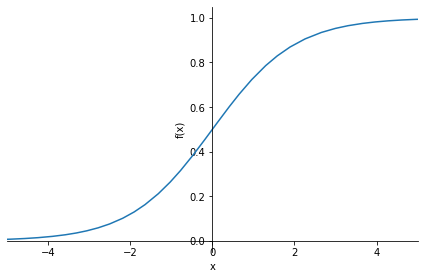

In [46]:
import sympy
sympy.plot("1/(1+exp(-x))", xlim=(-5,5));

PyTorch já define essa função para nós, então podemos modificar `calc_preds` para usá-la:

In [47]:
def calc_preds(coeffs, indeps): return torch.sigmoid((indeps*coeffs).sum(axis=1))

Vamos treinar um novo modelo agora, usando esta função atualizada para calcular as previsões:

In [48]:
coeffs = train_model(lr=100)

0.510; 0.327; 0.294; 0.207; 0.201; 0.199; 0.198; 0.197; 0.196; 0.196; 0.196; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 

A perda melhorou muito. Vamos verificar a precisão:

In [49]:
acc(coeffs)

tensor(0.8258)

Isso também melhorou! Aqui estão os coeficientes do nosso modelo treinado:

In [50]:
show_coeffs()

{'Age': tensor(-1.5061),
 'SibSp': tensor(-1.1575),
 'Parch': tensor(-0.4267),
 'LogFare': tensor(0.2543),
 'Sex_male': tensor(-10.3320),
 'Sex_female': tensor(8.4185),
 'Pclass_1': tensor(3.8389),
 'Pclass_2': tensor(2.1398),
 'Pclass_3': tensor(-6.2331),
 'Embarked_C': tensor(1.4771),
 'Embarked_Q': tensor(2.1168),
 'Embarked_S': tensor(-4.7958)}

Esses coeficientes parecem razoáveis - em geral, pessoas mais velhas e homens tinham menos chances de sobreviver, e os passageiros de primeira classe tinham mais chances de sobreviver.

## Enviando para o Kaggle

Agora que temos um modelo treinado, podemos preparar um envio para o Kaggle. Para fazer isso, primeiro precisamos ler o conjunto de teste:

In [51]:
tst_df = pd.read_csv(path/'test.csv')

Nesse caso, verifica-se que o conjunto de teste está faltando `Fare` para um passageiro. Vamos apenas preenchê-lo com `0` para evitar problemas:

In [52]:
tst_df['Fare'] = tst_df.Fare.fillna(0)

Agora podemos simplesmente copiar as mesmas etapas que fizemos para nosso conjunto de treinamento e fazer exatamente as mesmas coisas em nosso conjunto de teste para pré-processar os dados:

In [53]:
tst_df.fillna(modes, inplace=True)
tst_df['LogFare'] = np.log(tst_df['Fare']+1)
tst_df = pd.get_dummies(tst_df, columns=["Sex","Pclass","Embarked"])

tst_indep = tensor(tst_df[indep_cols].values, dtype=torch.float)
tst_indep = tst_indep / vals

Vamos calcular nossas previsões de quais passageiros sobreviveram no conjunto de teste:

In [54]:
tst_df['Survived'] = (calc_preds(tst_indep, coeffs)>0.5).int()

O exemplo de envio no site da competição Kaggle mostra que devemos carregar um CSV apenas com `PassengerId` e `Survived`, então vamos criá-lo e salvá-lo:

In [55]:
sub_df = tst_df[['PassengerId','Survived']]
sub_df.to_csv('sub.csv', index=False)

Podemos verificar as primeiras linhas do arquivo para garantir que pareça razoável:

In [56]:
!head sub.csv

PassengerId,Survived
892,0
893,0
894,0
895,0
896,0
897,0
898,1
899,0
900,1


Ao clicar em "salvar versão" no Kaggle e aguardar a execução do notebook, você verá que `sub.csv` aparece na guia "Dados". Clicar nesse arquivo mostrará um botão *Enviar*, que permite que você envie para a competição.

## Usando produto de matriz

Podemos deixar as coisas um pouco mais organizadas...

Dê uma olhada no cálculo mais interno que estamos fazendo para obter as previsões:

In [57]:
(val_indep*coeffs).sum(axis=1)

tensor([ 12.3288, -14.8119, -15.4540, -13.1513, -13.3512, -13.6469,   3.6248,   5.3429, -22.0878,   3.1233, -21.8742, -15.6421, -21.5504,
          3.9393, -21.9190, -12.0010, -12.3775,   5.3550, -13.5880,  -3.1015, -21.7237, -12.2081,  12.9767,   4.7427, -21.6525, -14.9135,
         -2.7433, -12.3210, -21.5886,   3.9387,   5.3890,  -3.6196, -21.6296, -21.8454,  12.2159,  -3.2275, -12.0289,  13.4560, -21.7230,
         -3.1366, -13.2462, -21.7230, -13.6831,  13.3092, -21.6477,  -3.5868, -21.6854, -21.8316, -14.8158,  -2.9386,  -5.3103, -22.2384,
        -22.1097, -21.7466, -13.3780, -13.4909, -14.8119, -22.0690, -21.6666, -21.7818,  -5.4439, -21.7407, -12.6551, -21.6671,   4.9238,
        -11.5777, -13.3323, -21.9638, -15.3030,   5.0243, -21.7614,   3.1820, -13.4721, -21.7170, -11.6066, -21.5737, -21.7230, -11.9652,
        -13.2382, -13.7599, -13.2170,  13.1347, -21.7049, -21.7268,   4.9207,  -7.3198,  -5.3081,   7.1065,  11.4948, -13.3135, -21.8723,
        -21.7230,  13.3603, -15.56

Multiplicar elementos juntos e depois somar linhas é idêntico a fazer um produto matriz-vetor! O Python usa o operador `@` para indicar produtos de matriz e é suportado pelos tensores PyTorch. Portanto, podemos replicar o cálculo acima de maneira mais simples:

In [58]:
val_indep@coeffs

tensor([ 12.3288, -14.8119, -15.4540, -13.1513, -13.3511, -13.6468,   3.6248,   5.3429, -22.0878,   3.1233, -21.8742, -15.6421, -21.5504,
          3.9393, -21.9190, -12.0010, -12.3775,   5.3550, -13.5880,  -3.1015, -21.7237, -12.2081,  12.9767,   4.7427, -21.6525, -14.9135,
         -2.7433, -12.3210, -21.5886,   3.9387,   5.3890,  -3.6196, -21.6296, -21.8454,  12.2159,  -3.2275, -12.0289,  13.4560, -21.7230,
         -3.1366, -13.2462, -21.7230, -13.6831,  13.3092, -21.6477,  -3.5868, -21.6854, -21.8316, -14.8158,  -2.9386,  -5.3103, -22.2384,
        -22.1097, -21.7466, -13.3780, -13.4909, -14.8119, -22.0690, -21.6666, -21.7818,  -5.4439, -21.7407, -12.6551, -21.6671,   4.9238,
        -11.5777, -13.3323, -21.9638, -15.3030,   5.0243, -21.7614,   3.1820, -13.4721, -21.7170, -11.6066, -21.5737, -21.7230, -11.9652,
        -13.2382, -13.7599, -13.2170,  13.1347, -21.7049, -21.7268,   4.9207,  -7.3198,  -5.3081,   7.1065,  11.4948, -13.3135, -21.8723,
        -21.7230,  13.3603, -15.56

Acontece também que isso é muito mais rápido, porque os produtos de matriz no PyTorch são altamente otimizados.

Vamos usar isso para substituir como `calc_preds` funciona:

In [59]:
def calc_preds(coeffs, indeps): return torch.sigmoid(indeps@coeffs)

Para fazer produtos matriz-matriz (que precisaremos na próxima seção), precisamos transformar `coeffs` em um vetor coluna (ou seja, uma matriz com uma única coluna), o que podemos fazer passando um segundo argumento `1` para `torch.rand()`, indicando que queremos que nossos coeficientes tenham uma coluna:

In [60]:
def init_coeffs(): return (torch.rand(n_coeff, 1)*0.1).requires_grad_()

Para fazer produtos matriz-matriz (que precisaremos na próxima seção), precisamos transformar `coeffs` em um vetor coluna (ou seja, uma matriz com uma única coluna), o que podemos fazer passando um segundo argumento `1` para `torch.rand()`, indicando que queremos que nossos coeficientes tenham uma coluna:

In [61]:
trn_dep = trn_dep[:,None]
val_dep = val_dep[:,None]

Agora podemos treinar nosso modelo como antes e confirmar que obtemos saídas idênticas...:

In [62]:
coeffs = train_model(lr=100)

0.512; 0.323; 0.290; 0.205; 0.200; 0.198; 0.197; 0.197; 0.196; 0.196; 0.196; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 

...e precisão idêntica:

In [63]:
acc(coeffs)

tensor(0.8258)

## Uma rede neural

Agora temos o que precisamos para implementar nossa rede neural.

Primeiro, precisaremos criar coeficientes para cada uma de nossas camadas. Nosso primeiro conjunto de coeficientes pegará nossas entradas `n_coeff` e criará saídas `n_hidden`. Podemos escolher qualquer `n_hidden` que quisermos - um número maior dá mais flexibilidade à nossa rede, mas torna mais lento e difícil de treinar. Portanto, precisamos de uma matriz de tamanho `n_coeff` por `n_hidden`. Dividiremos esses coeficientes por `n_hidden` para que, quando os somarmos na próxima camada, acabemos com números de magnitude semelhantes aos que começamos.

Em seguida, nossa segunda camada precisará pegar as entradas `n_hidden` e criar uma única saída, o que significa que precisamos de uma matriz `n_hidden` por `1` lá. A segunda camada também precisará de um termo constante adicionado.

In [64]:
def init_coeffs(n_hidden=20):
    layer1 = (torch.rand(n_coeff, n_hidden)-0.5)/n_hidden
    layer2 = torch.rand(n_hidden, 1)-0.3
    const = torch.rand(1)[0]
    return layer1.requires_grad_(),layer2.requires_grad_(),const.requires_grad_()

Agora que temos nossos coeficientes, podemos criar nossa rede neural. Os principais passos são os dois produtos da matriz, `indeps@l1` e `res@l2` (onde `res` é a saída da primeira camada). A saída da primeira camada é passada para `F.relu` (essa é a nossa não-linearidade), e a segunda é passada para `torch.sigmoid` como antes.

In [65]:
import torch.nn.functional as F

def calc_preds(coeffs, indeps):
    l1,l2,const = coeffs
    res = F.relu(indeps@l1)
    res = res@l2 + const
    return torch.sigmoid(res)

Finalmente, agora que temos mais de um conjunto de coeficientes, precisamos adicionar um loop para atualizar cada um:

In [66]:
def update_coeffs(coeffs, lr):
    for layer in coeffs:
        layer.sub_(layer.grad * lr)
        layer.grad.zero_()

Agora estamos prontos para treinar nosso modelo!

In [67]:
coeffs = train_model(lr=1.4)

0.543; 0.532; 0.520; 0.505; 0.487; 0.466; 0.439; 0.407; 0.373; 0.343; 0.319; 0.301; 0.286; 0.274; 0.264; 0.256; 0.250; 0.245; 0.240; 0.237; 0.234; 0.231; 0.229; 0.227; 0.226; 0.224; 0.223; 0.222; 0.221; 0.220; 

In [68]:
coeffs = train_model(lr=20)

0.543; 0.400; 0.260; 0.390; 0.221; 0.211; 0.197; 0.195; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 

Parece bom -- nossa perda é menor do que antes. Vamos ver se isso se traduz em um resultado melhor no conjunto de validação:

In [69]:
acc(coeffs)

tensor(0.8258)

Neste caso, nossa rede neural não está apresentando melhores resultados do que o modelo linear. Isso não é surpreendente; esse conjunto de dados é muito pequeno e muito simples, e não é o tipo de coisa em que esperaríamos que as redes neurais se destacassem. Além disso, nosso conjunto de validação é muito pequeno para ver de forma confiável muita diferença de precisão. Mas o importante é que agora sabemos exatamente como é uma rede neural real!

## Deep learning

A rede neural na seção anterior usa apenas uma camada oculta, portanto, não conta como aprendizado "profundo". Mas podemos usar exatamente a mesma técnica para tornar nossa rede neural profunda, adicionando mais multiplicações de matrizes.

Primeiro, precisaremos criar coeficientes adicionais para cada camada:

In [70]:
def init_coeffs():
    hiddens = [10, 10]  # <-- set this to the size of each hidden layer you want
    sizes = [n_coeff] + hiddens + [1]
    n = len(sizes)
    layers = [(torch.rand(sizes[i], sizes[i+1])-0.3)/sizes[i+1]*4 for i in range(n-1)]
    consts = [(torch.rand(1)[0]-0.5)*0.1 for i in range(n-1)]
    for l in layers+consts: l.requires_grad_()
    return layers,consts

Você notará aqui que há muitas constantes confusas para obter os números aleatórios nos intervalos certos. Quando você treinar o modelo em um momento, verá que as menores alterações nessas inicializações podem fazer com que nosso modelo falhe no treinamento! Esta é uma das principais razões pelas quais o aprendizado profundo não conseguiu fazer muito progresso nos primeiros dias - é muito meticuloso obter um bom ponto de partida para nossos coeficientes. Hoje em dia, temos formas de lidar com isso, que aprenderemos em outros notebooks (do Kagle).

Nosso aprendizado profundo `calc_preds` parece o mesmo de antes, mas agora percorremos cada camada, em vez de listá-las separadamente:

In [71]:
import torch.nn.functional as F

def calc_preds(coeffs, indeps):
    layers,consts = coeffs
    n = len(layers)
    res = indeps
    for i,l in enumerate(layers):
        res = res@l + consts[i]
        if i!=n-1: res = F.relu(res)
    return torch.sigmoid(res)

Também precisamos de uma pequena atualização para `update_coeffs`, já que temos `layers` e `consts` separados agora:

In [72]:
def update_coeffs(coeffs, lr):
    layers,consts = coeffs
    for layer in layers+consts:
        layer.sub_(layer.grad * lr)
        layer.grad.zero_()

Vamos treinar nosso modelo...

In [73]:
coeffs = train_model(lr=4)

0.521; 0.483; 0.427; 0.379; 0.379; 0.379; 0.379; 0.378; 0.378; 0.378; 0.378; 0.378; 0.378; 0.378; 0.378; 0.378; 0.377; 0.376; 0.371; 0.333; 0.239; 0.224; 0.208; 0.204; 0.203; 0.203; 0.207; 0.197; 0.196; 0.195; 

...e verificar sua precisão:

In [74]:
acc(coeffs)

tensor(0.8258)